**Meeter wants to launch new wave of targeted commercials and needs you to help them profile their customers**

**Background:** Meeter, an online dating app, is
preparing a new marketing strategy, and would
like to deploy “smart”, i.e. targeted,
commercials for their biggest customer groups.
Thus, they ran a set of speed dating events,
and collected data

**Goal:** find out what are the typical user
***profiles, their characteristics and traits***, and
visualize those results

**Data source:**
http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/

In [122]:
!pip install sweetviz -qq

In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer

In [125]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1TMcPaBvS8SjdR1B9EdFcz72zDS4HnqLV', encoding='ISO-8859-1')

In [126]:
data.shape

(8378, 195)

In [127]:
data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


### Basic report

In [128]:
my_report = sv.analyze(data,
                      pairwise_analysis="off")

my_report.show_notebook()

#Sweetviz provides us with information including the distribution of genders (approximately equal), the characteristics sought in the opposite gender, etc.
#We are interested in the 1_1 data (preparing our dataset for clustering as indicated there)

Output hidden; open in https://colab.research.google.com to view.

Check if the characteristics for matches change significantly




In [129]:
# Filtering data to get only rows where match = 1
filtered_data = data[data['match'] == 1]

# Generating Sweetviz report for the filtered data
my_report = sv.analyze(filtered_data, pairwise_analysis="off")

# Displaying the report in the notebook
my_report.show_notebook()

Output hidden; open in https://colab.research.google.com to view.

In [130]:
my_report.show_html(filepath='basic_report.html',  layout='vertical')

Report basic_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [131]:
data.shape

(8378, 195)

Meaning of attributes

attr1_1 - Attractive

sinc1_1 - Sincere

intel1_1 - Intelligent

fun1_1 - Fun

amb1_1 - Ambitious

shar1_1 - Has shared interests/hobbies

In [132]:
# Creating a subset of the data
data_subset = data.loc[:, ['iid', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].copy()
data_subset.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_subset.drop(columns=['iid'], inplace=True)  # Removing the iid column

In [133]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, 0 to 8356
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   attr1_1   544 non-null    float64
 1   sinc1_1   544 non-null    float64
 2   intel1_1  544 non-null    float64
 3   fun1_1    543 non-null    float64
 4   amb1_1    542 non-null    float64
 5   shar1_1   541 non-null    float64
dtypes: float64(6)
memory usage: 30.1 KB


In [134]:
data_subset.median()

attr1_1     20.0
sinc1_1     18.0
intel1_1    20.0
fun1_1      18.0
amb1_1      10.0
shar1_1     11.0
dtype: float64

In [135]:
rows_with_zeros = data_subset[(data_subset == 0).any(axis=1)]
rows_with_zeros

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
10,45.0,5.0,25.0,20.0,0.0,5.0
20,35.0,10.0,35.0,10.0,10.0,0.0
100,35.0,20.0,20.0,20.0,0.0,5.0
110,60.0,0.0,0.0,40.0,0.0,0.0
150,50.0,0.0,30.0,10.0,0.0,10.0
...,...,...,...,...,...,...
8246,25.0,20.0,20.0,20.0,0.0,15.0
8268,40.0,10.0,20.0,10.0,0.0,20.0
8290,20.0,20.0,20.0,20.0,0.0,20.0
8334,40.0,20.0,20.0,20.0,0.0,0.0


In [136]:
data_subset = data_subset.fillna(0) # Filling missing values with zeros, due to the fact that missing data is mainly in those waves where 100 points were to be distributed among all the features. Most often, people left fields empty where they did not allocate any points.

In [137]:
data_subset.shape

(551, 6)

In [138]:
data_subset

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,15.0,20.0,20.0,15.0,15.0,15.0
10,45.0,5.0,25.0,20.0,0.0,5.0
20,35.0,10.0,35.0,10.0,10.0,0.0
30,20.0,20.0,20.0,20.0,10.0,10.0
40,20.0,5.0,25.0,25.0,10.0,15.0
...,...,...,...,...,...,...
8268,40.0,10.0,20.0,10.0,0.0,20.0
8290,20.0,20.0,20.0,20.0,0.0,20.0
8312,30.0,3.0,30.0,30.0,3.0,4.0
8334,40.0,20.0,20.0,20.0,0.0,0.0


In [139]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, 0 to 8356
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   attr1_1   551 non-null    float64
 1   sinc1_1   551 non-null    float64
 2   intel1_1  551 non-null    float64
 3   fun1_1    551 non-null    float64
 4   amb1_1    551 non-null    float64
 5   shar1_1   551 non-null    float64
dtypes: float64(6)
memory usage: 30.1 KB


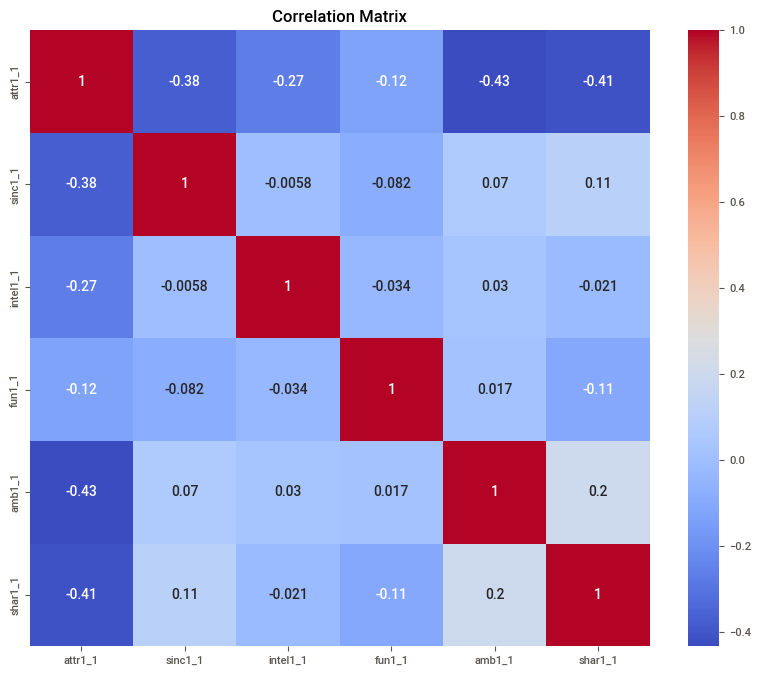

In [140]:
# Checking the correlation between features to reduce noise - added during code iteration
# Calculating the correlation matrix
correlation_matrix = data_subset.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [141]:
# Setting the correlation threshold
threshold = 0.2

# List of columns with low correlation
low_correlation_features = []

# Checking each column
for column in correlation_matrix.columns:
    if all(correlation_matrix[column].abs().drop(column) < threshold):
        low_correlation_features.append(column)

low_correlation_features

['fun1_1']

Excluding the feature fun1_1 in further analysis



In [142]:
# Scaling data
# StandardScaler will standardize the range of values so that no feature dominates
scaler = StandardScaler()
data_subset_scaled = scaler.fit_transform(data_subset)

# Performing hierarchical clustering
# n_clusters is the number of clusters we want to obtain
# affinity - distance metric (euclidean is the standard Euclidean distance)
# The Euclidean distance between two points is the length of the line segment connecting them.
# Linkage is the method of merging clusters

hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels_hierarchical = hierarchical.fit_predict(data_subset_scaled) # cluster labels

# Clustering result - assigning each point to a specific cluster
labels_hierarchical # The clustering result clearly illustrates the differences between the hierarchical clustering method (no noise - negative values and a defined number of clusters) and DBSCAN.

array([0, 3, 2, 0, 2, 0, 2, 0, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 0, 0,
       2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 3, 0, 0, 0,
       2, 0, 3, 3, 0, 0, 2, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 1, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 2, 1, 0, 3, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 2, 3, 3, 1, 1, 0, 0, 0, 3, 3, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 2, 3, 0, 0, 2, 2, 1, 3, 2, 0, 0, 0, 1, 0, 3, 0, 0,
       3, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1,

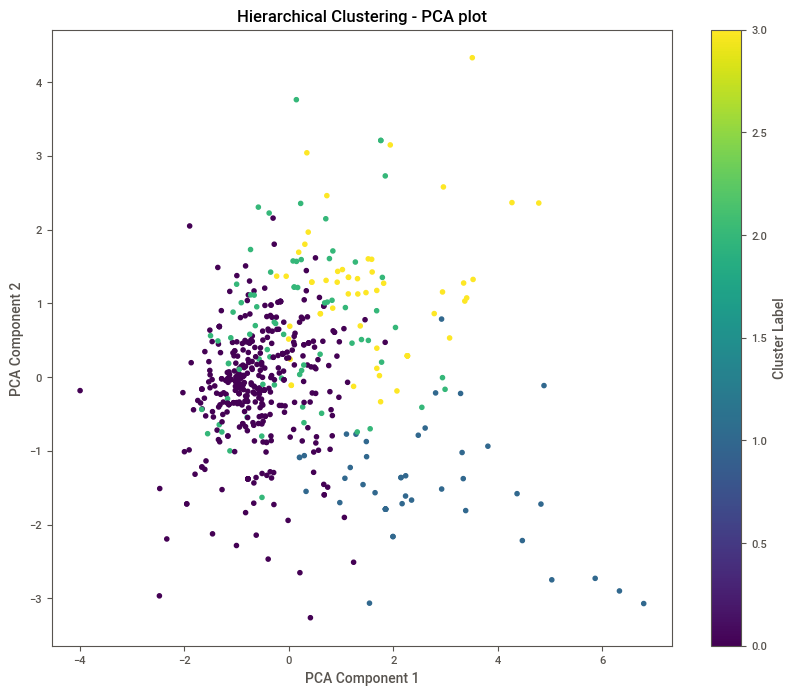

In [143]:
# Dimensionality reduction using PCA
# PCA reduces the number of dimensions to 2 to make it easier to visualize
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_subset_scaled)

# PCA visualization, the colors of the points represent our clusters
plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_hierarchical, cmap='viridis')
plt.title('Hierarchical Clustering - PCA plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

t-SNE is more suitable for visualizing complex, non-linear structures in high-dimensional data. It is particularly useful for identifying clusters and local patterns. This is the plot I will be using in further analysis.


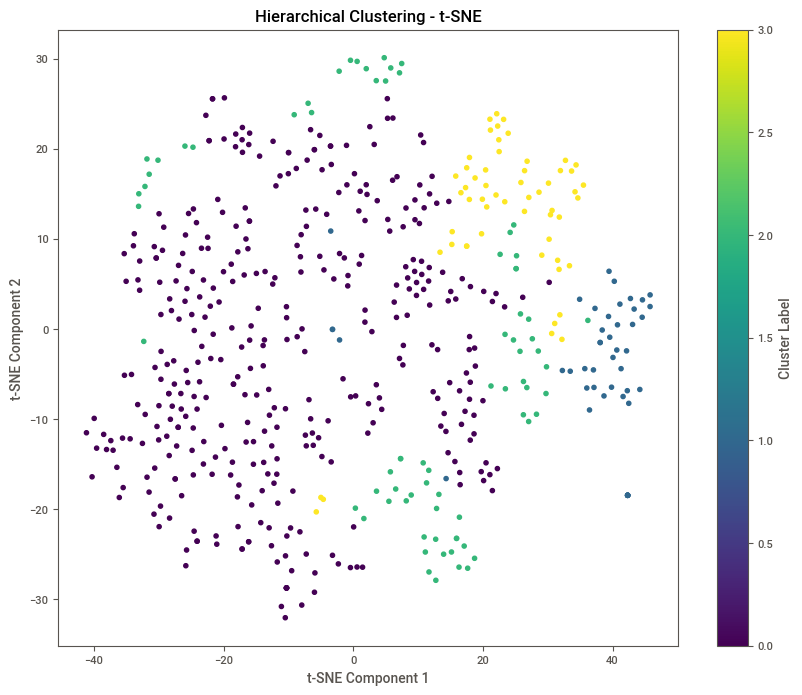

In [144]:
# Dimensionality reduction using t-SNE
# t-SNE reduces the number of dimensions to 2
tsne = TSNE(n_components=2, random_state=1)
data_tsne = tsne.fit_transform(data_subset_scaled)

# t-SNE visualization, point colors represent our clusters
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels_hierarchical, cmap='viridis')
plt.title('Hierarchical Clustering - t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [145]:
# Calculating silhouette - checking the quality of the clustering
# Calculate the average silhouette value for the entire dataset
silhouette_mean = silhouette_score(data_subset_scaled, labels_hierarchical)
# Calculate silhouette values for each sample (for visualization purposes)
sample_silhouette_values = silhouette_samples(data_subset_scaled, labels_hierarchical)
# Check the average silhouette value
silhouette_mean

0.2391647357882882

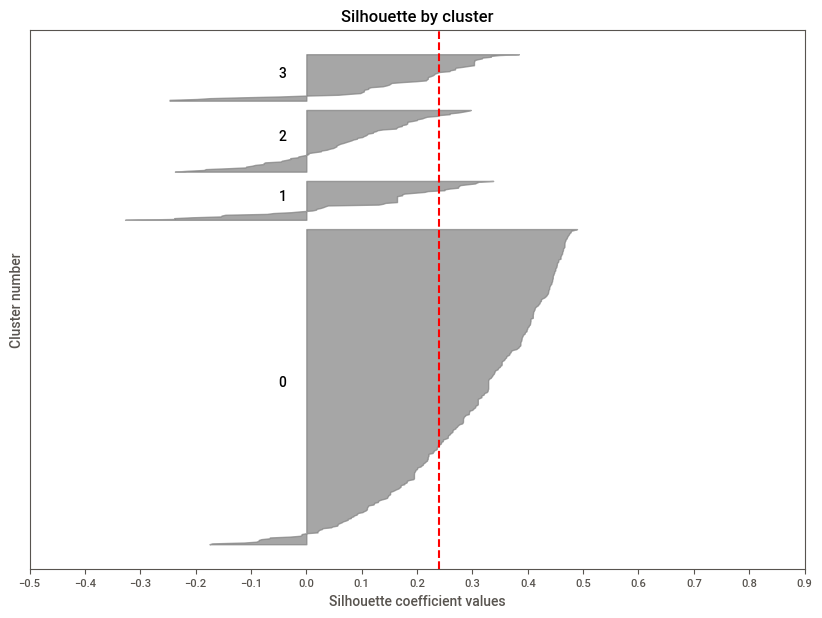

In [146]:
# Silhouette visualization
figure, ax1 = plt.subplots(1, 1)
figure.set_size_inches(10, 7)

lower = 10  # Initial value of the lower boundary for the first cluster
for i in range(4):  # 4 clusters
    cluster_silhouette_value = sample_silhouette_values[labels_hierarchical == i]
    cluster_silhouette_value.sort()  # Sort silhouette values in the cluster
    size_cluster_i = cluster_silhouette_value.shape[0]
    upper = lower + size_cluster_i
    ax1.fill_betweenx(np.arange(lower, upper),
                      0, cluster_silhouette_value,
                      facecolor='gray', edgecolor='gray', alpha=0.7)
    # cluster label in the middle
    ax1.text(-0.05, lower + 0.5 * size_cluster_i, str(i))
    lower = upper + 10  # Space between clusters

ax1.set_title("Silhouette by cluster")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster number")

# Vertical line marks the average silhouette value
ax1.axvline(x=silhouette_mean, color="red", linestyle="--")
# Hide y-axis labels
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.5, 1, 0.1))

# Display the plot
plt.show()

In [147]:
# Adding cluster labels to the unscaled data subset
data_subset_with_labels = data_subset.copy()
data_subset_with_labels['cluster_hierarchical'] = labels_hierarchical

# Mean feature values for each cluster on unscaled data
cluster_means = data_subset_with_labels.groupby('cluster_hierarchical').mean()
cluster_means

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
cluster_hierarchical,,,,,,
0,18.117112,19.758636,19.423075,17.113048,12.568369,13.178048
1,45.453830,8.278936,10.534255,8.108723,4.640638,8.089787
2,21.894324,10.953784,30.995270,16.224459,8.909054,10.955541
3,32.296250,14.584821,16.424107,26.680179,4.985000,5.029643


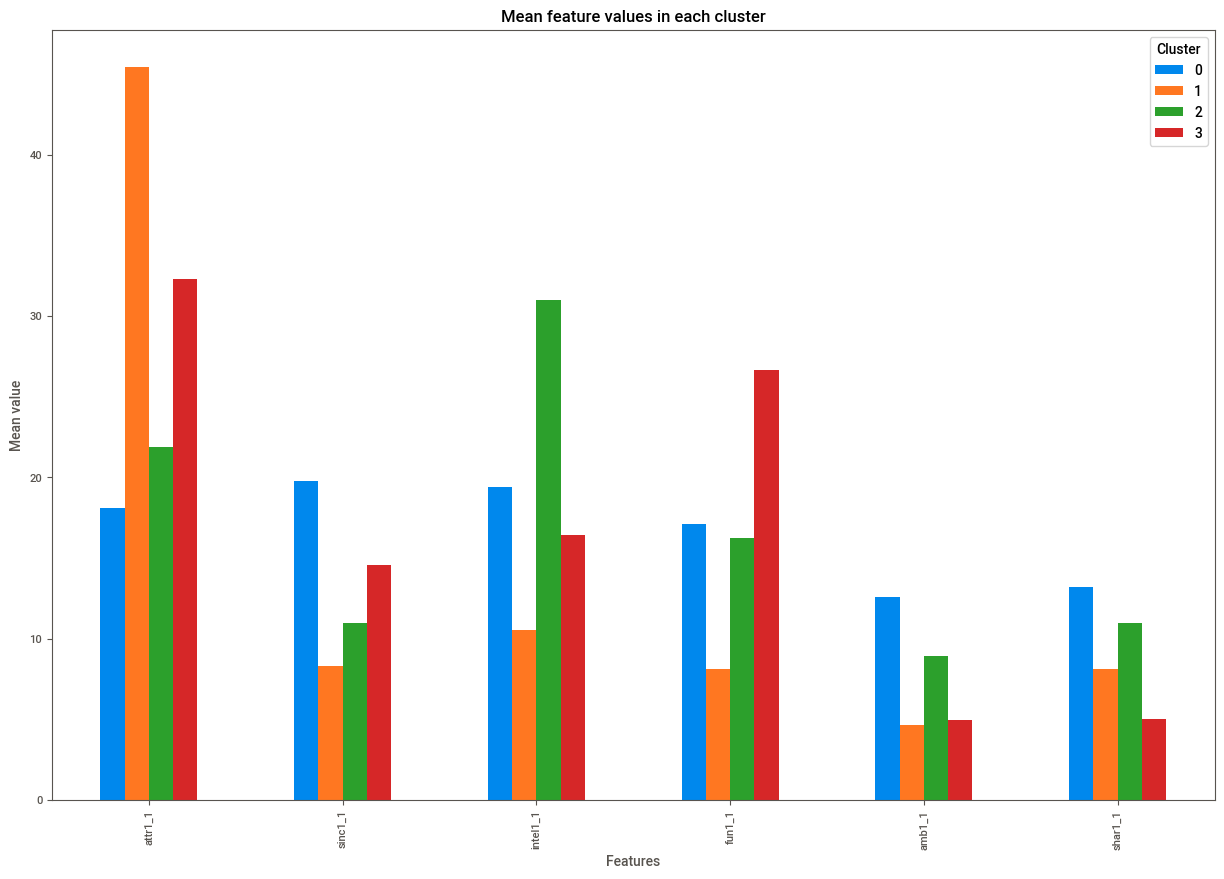

In [148]:
# Analysis of partner preferences in clusters
# Preparing bar plots for the mean feature values in clusters
cluster_means.T.plot(kind='bar', figsize=(15, 10))
plt.title('Mean feature values in each cluster')
plt.xlabel('Features')
plt.ylabel('Mean value')
plt.legend(title='Cluster')
plt.show()


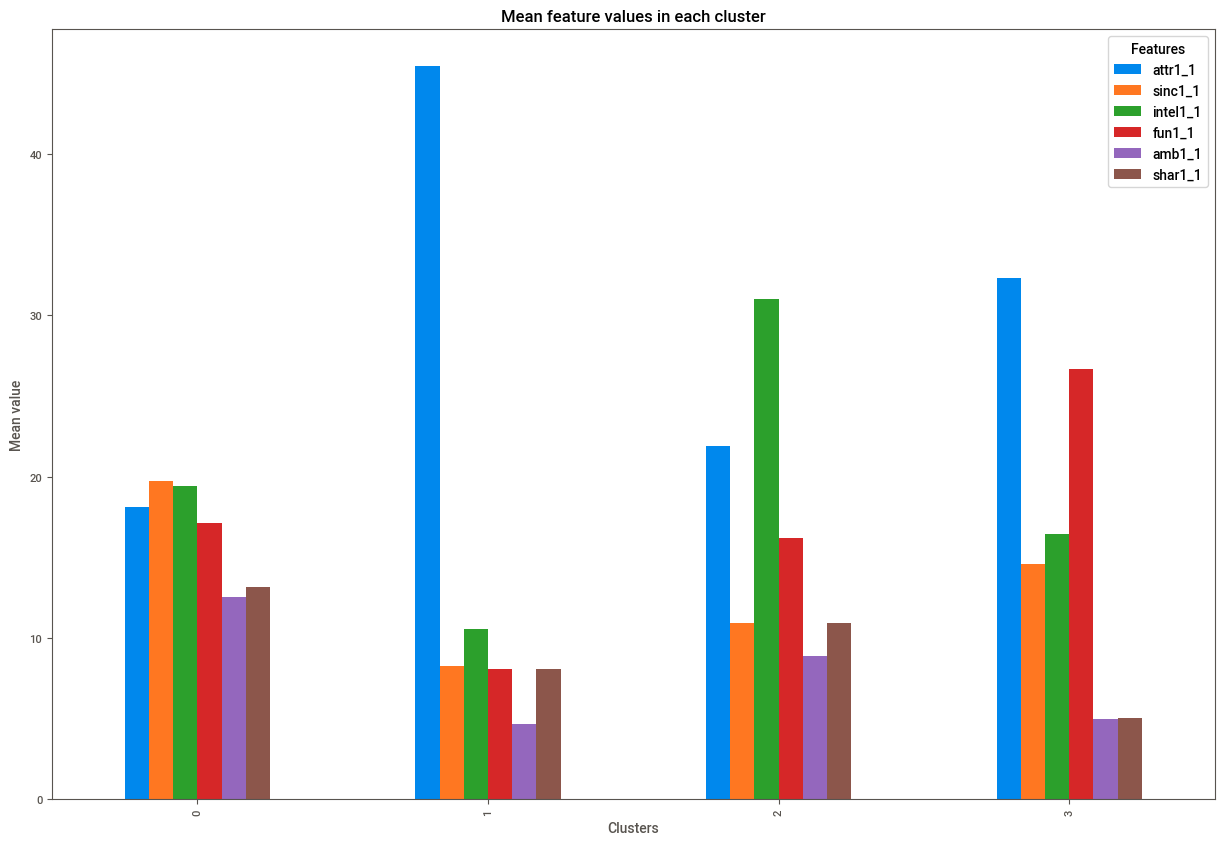

In [149]:
# Analysis of partner preferences in clusters - visualization in a different way
# Preparing bar plots for the mean feature values in clusters
cluster_means.plot(kind='bar', figsize=(15, 10))
plt.title('Mean feature values in each cluster')
plt.xlabel('Clusters')
plt.ylabel('Mean value')
plt.legend(title='Features')
plt.show()


Adding demographic data

In [150]:
data_subset_for_analysis = data_subset_with_labels.merge(data[['iid']], left_index=True, right_index=True)

In [151]:
demographic_columns = ['iid','gender', 'age', 'race']
data_demographics = data[demographic_columns]
data_demographics.dtypes

iid         int64
gender      int64
age       float64
race      float64
dtype: object

In [152]:
data_demographics.info() # Checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iid     8378 non-null   int64  
 1   gender  8378 non-null   int64  
 2   age     8283 non-null   float64
 3   race    8315 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 261.9 KB


In [153]:
data_demographics = data_demographics.fillna(data_demographics.median()) # Filling missing values with the median

In [154]:
data_subset_demographics_with_clusters = data_subset_for_analysis.merge(data_demographics[['iid', 'gender', 'age', 'race']], on='iid', how='left')

In [155]:
data_subset_demographics_with_clusters.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_subset_demographics_with_clusters.drop(columns=['iid'], inplace=True)

In [156]:
data_subset_demographics_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, 0 to 8356
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   attr1_1               551 non-null    float64
 1   sinc1_1               551 non-null    float64
 2   intel1_1              551 non-null    float64
 3   fun1_1                551 non-null    float64
 4   amb1_1                551 non-null    float64
 5   shar1_1               551 non-null    float64
 6   cluster_hierarchical  551 non-null    int64  
 7   gender                551 non-null    int64  
 8   age                   551 non-null    float64
 9   race                  551 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 47.4 KB


In [157]:
# Calculating the mean values of demographic features for each cluster (only for numeric column, i.e., age)
numeric_columns = ['age']
cluster_demographics = data_subset_demographics_with_clusters.groupby('cluster_hierarchical')[numeric_columns].mean()
cluster_demographics_1 = data_subset_demographics_with_clusters.groupby('cluster_hierarchical')[numeric_columns].median()

cluster_demographics  # Mean age

,age
cluster_hierarchical,
0,26.315508
1,25.851064
2,26.675676
3,26.607143


In [158]:
cluster_demographics_1  # Median age

,age
cluster_hierarchical,
0,26.0
1,26.0
2,26.0
3,26.0


In [159]:
# Checking the distribution of gender in clusters (before visualization for creating a nicer chart in Excel later this approach is repeated)
gender_counts_per_cluster = data_subset_demographics_with_clusters.groupby('cluster_hierarchical')['gender'].value_counts().unstack()
gender_counts_per_cluster

gender,0,1
cluster_hierarchical,,
0,203,171
1,12,35
2,44,30
3,15,41


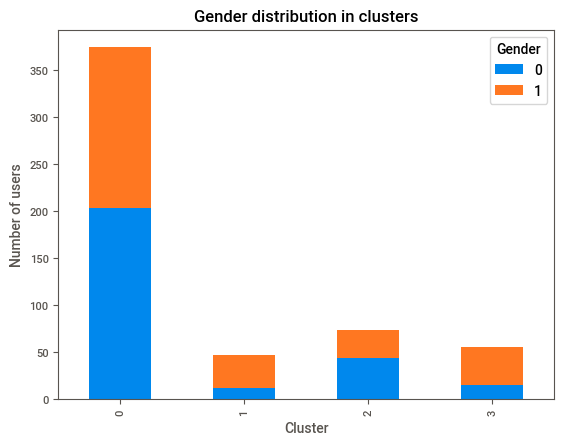

In [160]:
# Visualization of gender distribution in clusters
gender_distribution = data_subset_demographics_with_clusters.groupby(['cluster_hierarchical', 'gender']).size().unstack()
gender_distribution.plot(kind='bar', stacked=True)
plt.title('Gender distribution in clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of users')
plt.legend(title='Gender')
plt.show()

cluster_hierarchical
0    26.315508
1    25.851064
2    26.675676
3    26.607143
Name: age, dtype: float64


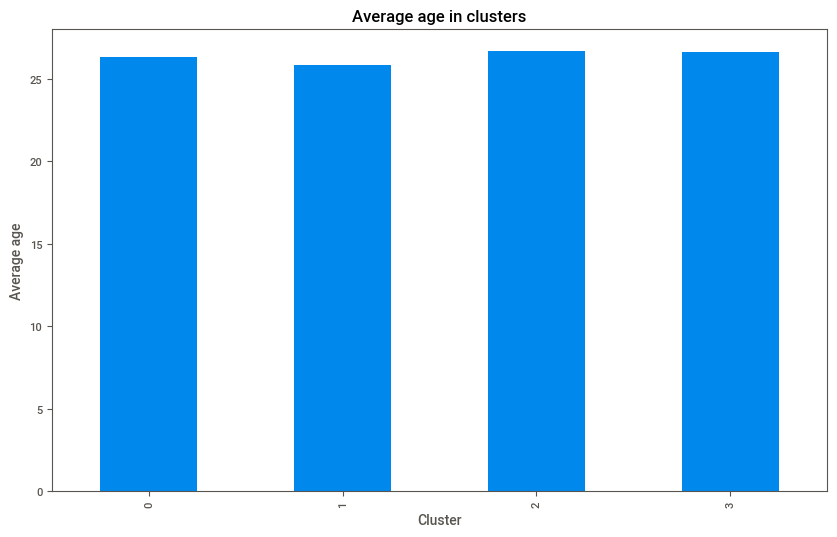

In [161]:
# Analysis of the average age in clusters
age_distribution = data_subset_demographics_with_clusters.groupby('cluster_hierarchical')['age'].mean()
print(age_distribution)

# Visualization of the average age in clusters
age_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Average age in clusters')
plt.xlabel('Cluster')
plt.ylabel('Average age')
plt.show()

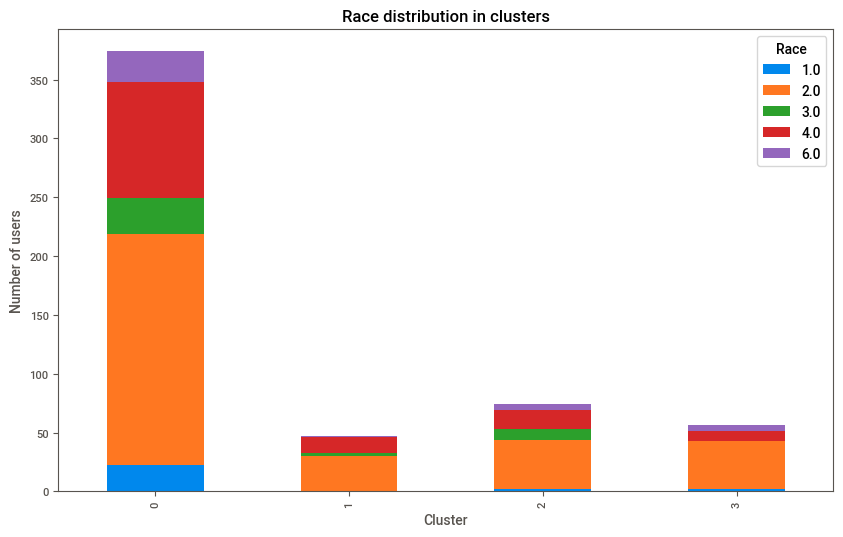

In [162]:
# Visualization of race distribution in clusters

race_mapping = {
    1: 'Black/African American',
    2: 'European/Caucasian-American',
    3: 'Latino/Latino-American',
    4: 'Asian/Pacific Islander/Asian-American',
    5: 'Native American',
    6: 'Other'
}

data_demographics['race'] = data_subset_demographics_with_clusters['race'].map(race_mapping)

race_distribution = data_subset_demographics_with_clusters.groupby(['cluster_hierarchical', 'race']).size().unstack()
race_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Race distribution in clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of users')
plt.legend(title='Race')
plt.show()

In [163]:
race_counts_per_cluster = data_subset_demographics_with_clusters.groupby('cluster_hierarchical')['race'].value_counts().unstack()
race_counts_per_cluster

race,1.0,2.0,3.0,4.0,6.0
cluster_hierarchical,,,,,
0,22.0,197.0,30.0,99.0,26.0
1,NaN,30.0,3.0,13.0,1.0
2,2.0,42.0,9.0,16.0,5.0
3,2.0,41.0,NaN,8.0,5.0


In [164]:
# Checking employment data in clusters
career_column = ['iid','career_c']
data_career = data[career_column]
data_career_with_labels = data_subset_for_analysis.merge(data_career[['iid', 'career_c']], on='iid', how='left')
data_career_with_labels = data_career_with_labels.fillna(data_career_with_labels.median()) # Filling missing values with the median
data_career_with_labels.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_career_with_labels.drop(columns=['iid'], inplace=True)
data_career_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, 0 to 8356
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   attr1_1               551 non-null    float64
 1   sinc1_1               551 non-null    float64
 2   intel1_1              551 non-null    float64
 3   fun1_1                551 non-null    float64
 4   amb1_1                551 non-null    float64
 5   shar1_1               551 non-null    float64
 6   cluster_hierarchical  551 non-null    int64  
 7   career_c              551 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 38.7 KB


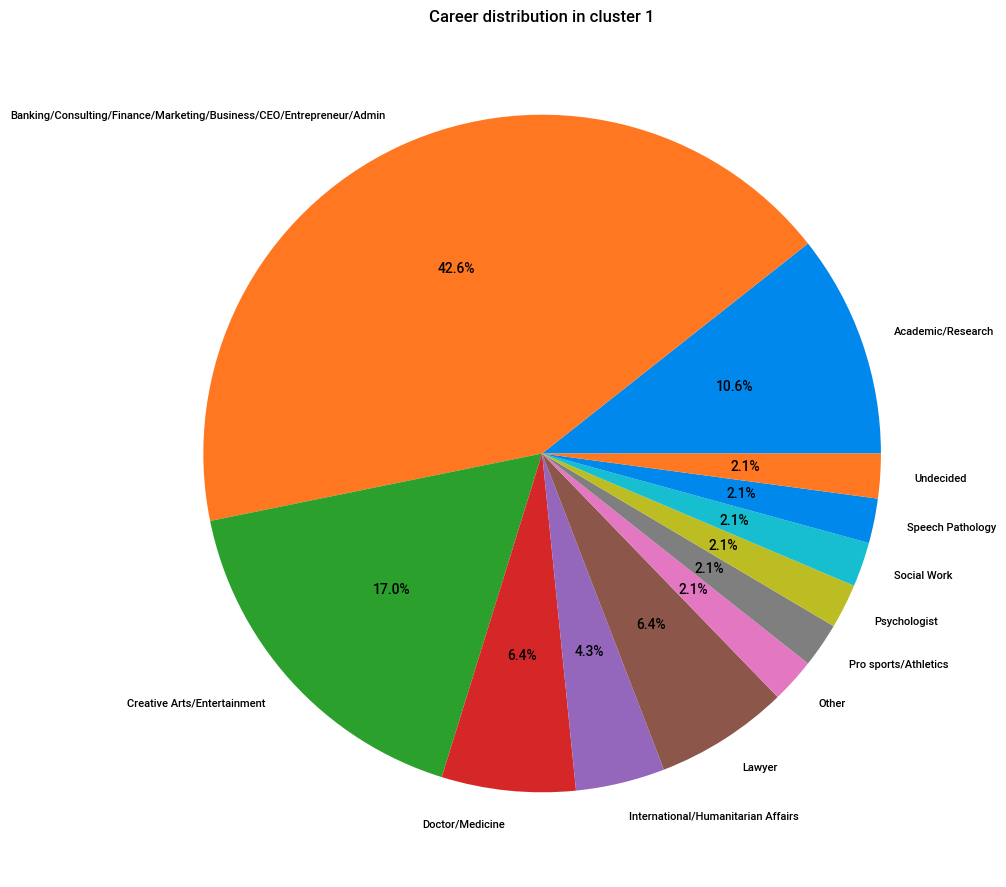

In [165]:
# Mapping career_c values to labels
career_labels = {
    1: 'Lawyer',
    2: 'Academic/Research',
    3: 'Psychologist',
    4: 'Doctor/Medicine',
    5: 'Engineer',
    6: 'Creative Arts/Entertainment',
    7: 'Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin',
    8: 'Real Estate',
    9: 'International/Humanitarian Affairs',
    10: 'Undecided',
    11: 'Social Work',
    12: 'Speech Pathology',
    13: 'Politics',
    14: 'Pro sports/Athletics',
    15: 'Other',
    16: 'Journalism',
    17: 'Architecture'
}

# Mapping labels
data_career_with_labels['career_c_label'] = data_career_with_labels['career_c'].map(career_labels)

# Analysis of the largest cluster (1)
cluster_0_data = data_career_with_labels[data_career_with_labels['cluster_hierarchical'] == 1]
career_distribution_cluster_0 = cluster_0_data.groupby(['career_c_label']).size()

# Visualization of career distribution in cluster 1
plt.figure(figsize=(11, 11))
career_distribution_cluster_0.plot(kind='pie', autopct='%1.1f%%')
plt.title('Career distribution in cluster 1')
plt.ylabel('')  # Hide the y-label
plt.show()

In [166]:
# Counting the occurrences of career labels (nicer visualization in Excel)
career_counts_per_cluster = data_career_with_labels.groupby('cluster_hierarchical')['career_c_label'].value_counts().unstack()
career_counts_per_cluster

career_c_label,Academic/Research,Architecture,Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin,Creative Arts/Entertainment,Doctor/Medicine,Engineer,International/Humanitarian Affairs,Journalism,Lawyer,Other,Politics,Pro sports/Athletics,Psychologist,Real Estate,Social Work,Speech Pathology,Undecided
cluster_hierarchical,,,,,,,,,,,,,,,,,
0,116.0,NaN,88.0,37.0,21.0,11.0,28.0,1.0,26.0,3.0,1.0,NaN,9.0,2.0,7.0,1.0,23.0
1,5.0,NaN,20.0,8.0,3.0,NaN,2.0,NaN,3.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0
2,22.0,1.0,12.0,6.0,2.0,2.0,2.0,1.0,11.0,NaN,2.0,NaN,6.0,1.0,5.0,NaN,1.0
3,9.0,NaN,24.0,7.0,NaN,1.0,3.0,NaN,7.0,1.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN


In [167]:
# Names of interests that we will analyze
interests_column = ['iid', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
data_interests = data[interests_column]
data_interests_with_labels = data_subset_for_analysis.merge(data_interests[['iid', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']], on='iid', how='left')

In [168]:
data_interests_with_labels = data_interests_with_labels.fillna(data_interests_with_labels.median())  # Filling missing values with the median
data_interests_with_labels.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_interests_with_labels.drop(columns=['iid'], inplace=True)

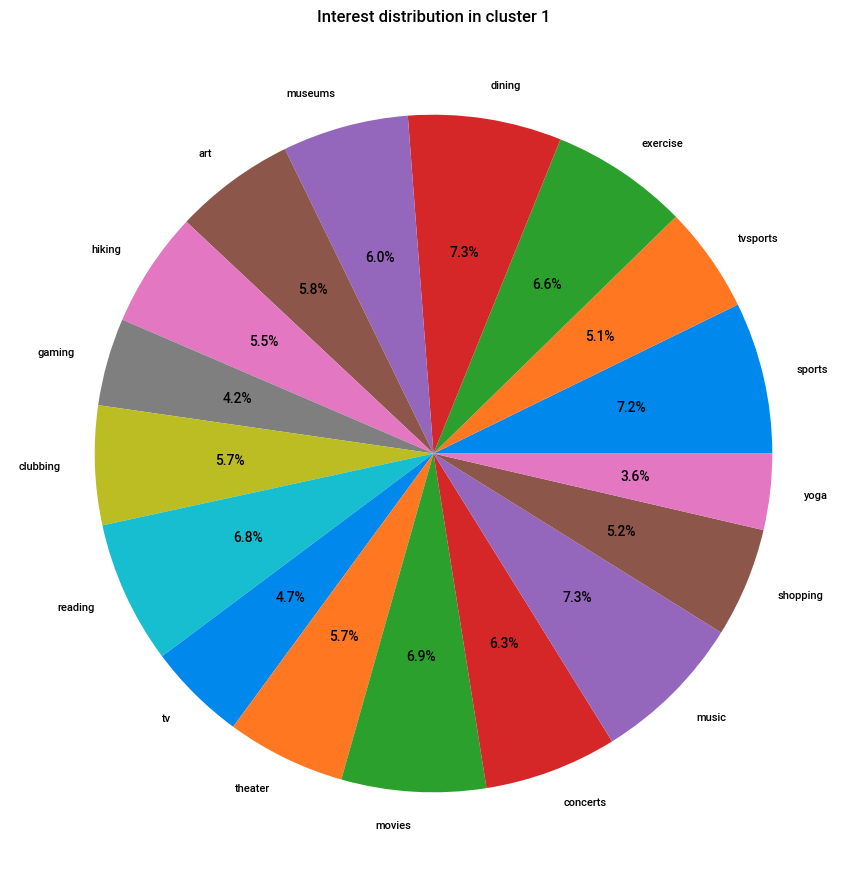

In [169]:
# Analysis of the largest cluster (1)
cluster_0_data_interests = data_interests_with_labels[data_interests_with_labels['cluster_hierarchical'] == 1]
interest_distribution_cluster_0 = cluster_0_data_interests[interests_column[1:]].sum()

# Visualization of interest distribution in cluster 1
plt.figure(figsize=(11, 11))
interest_distribution_cluster_0.plot(kind='pie', autopct='%1.1f%%')
plt.title('Interest distribution in cluster 1')
plt.ylabel('')
plt.show()

In [170]:
# For a nice visualization in Excel

# Summing interests in cluster 1
interest_distribution_cluster_0 = cluster_0_data_interests[interests_column[1:]].sum()

# Converting to percentages
interest_distribution_cluster_0_percentage = (interest_distribution_cluster_0 / interest_distribution_cluster_0.sum()) * 100

interest_distribution_cluster_0_percentage

sports      7.242945
tvsports    5.072035
exercise    6.571936
dining      7.321887
museums     6.019341
art         5.782514
hiking      5.525952
gaming      4.183935
clubbing    5.683837
reading     6.808763
tv          4.716795
theater     5.683837
movies      6.887705
concerts    6.335110
music       7.302151
shopping    5.229919
yoga        3.631340
dtype: float64

# Clustering by gender



In [171]:
data_women_filter = data[data['gender'] == 0]
data_men_filter = data[data['gender'] == 1]

In [172]:
# Starting with the analysis of men - fewer comments because the process on the entire population has already been conducted
data_men = data_men_filter.loc[:, ['iid', 'attr1_1', 'sinc1_1', 'intel1_1', 'amb1_1', 'shar1_1']].copy()

data_men.drop_duplicates(subset=['iid'], inplace=True)
data_men.drop(columns=['iid'], inplace=True)
data_men = data_men.fillna(data_men.median())

scaler = StandardScaler()
data_men_scaled = scaler.fit_transform(data_men)

hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels_hierarchical_men = hierarchical.fit_predict(data_men_scaled)

labels_hierarchical_men

array([1, 3, 0, 1, 0, 1, 1, 0, 1, 3, 2, 0, 2, 2, 0, 0, 2, 2, 1, 2, 0, 0,
       0, 1, 1, 2, 0, 2, 2, 1, 0, 3, 2, 1, 1, 2, 0, 0, 0, 1, 1, 2, 2, 0,
       1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 3, 1, 0, 0, 2, 2, 3, 1, 3, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 0, 2, 3, 0, 2, 2,
       0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 3, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 0, 3, 3, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 0,
       2, 3, 3, 0, 3, 3, 0, 0, 0, 2, 2, 3, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0,
       0, 2, 2, 3, 0, 3, 0, 2, 2, 0, 0, 1, 0, 3, 3, 1, 1, 3, 0, 3, 1, 2,
       2, 1, 3, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 1, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0,
       0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1])

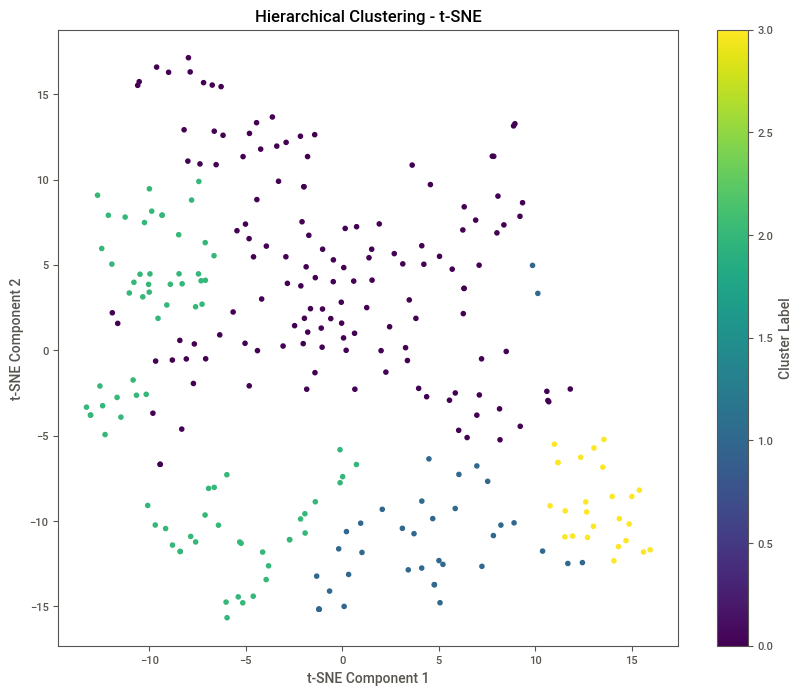

In [173]:
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_men_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels_hierarchical_men, cmap='viridis')
plt.title('Hierarchical Clustering - t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [174]:
# Calculating silhouette
silhouette_mean_men = silhouette_score(data_men_scaled, labels_hierarchical_men)
sample_silhouette_values = silhouette_samples(data_men_scaled, labels_hierarchical_men)
silhouette_mean_men

0.16214264931875494

In [175]:
lower = 10
for i in range(4):  # 4 clusters
    cluster_silhouette_value = sample_silhouette_values[labels_hierarchical_men == i]
    cluster_silhouette_value.sort()  # Sorting silhouette values within the cluster
    size_cluster_i = cluster_silhouette_value.shape[0]
    upper = lower + size_cluster_i
    ax1.fill_betweenx(np.arange(lower, upper),
                      0, cluster_silhouette_value,
                      facecolor='gray', edgecolor='gray', alpha=0.7)
    # Cluster label in the middle
    ax1.text(-0.05, lower + 0.5 * size_cluster_i, str(i))
    lower = upper + 10  # Spacing between clusters

ax1.set_title("Silhouette in clustering")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster number")

# Vertical line indicates the mean silhouette value
ax1.axvline(x=silhouette_mean_men, color="red", linestyle="--")
# Hiding y-axis labels
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.5, 1, 0.1))

# Displaying the plot
plt.show()

In [176]:
# Conclusions from clustering data about men
data_subset_men_with_labels = data_men.copy()
data_subset_men_with_labels['cluster_hierarchical_men'] = labels_hierarchical_men

# Calculating mean feature values for each cluster
cluster_means_men = data_subset_men_with_labels.groupby('cluster_hierarchical_men').mean()
cluster_means_men

,attr1_1,sinc1_1,intel1_1,amb1_1,shar1_1
cluster_hierarchical_men,,,,,
0,21.211957,16.833478,18.737971,11.028696,15.925000
1,37.967895,10.195789,23.090526,3.599474,5.783684
2,22.952500,21.117500,22.713947,9.055263,6.628026
3,57.000000,8.920000,7.280000,4.080000,4.680000


In [177]:
# Number of people in each cluster
data_subset_men_with_labels['cluster_hierarchical_men'].value_counts()

cluster_hierarchical_men
0    138
2     76
1     38
3     25
Name: count, dtype: int64

In [178]:
data_subset_demographics_with_clusters_men = data_subset_men_with_labels.merge(data_men_filter[['iid']], left_index=True, right_index=True)

In [179]:
data_subset_demographics_with_clusters_men.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 100 to 8356
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attr1_1                   277 non-null    float64
 1   sinc1_1                   277 non-null    float64
 2   intel1_1                  277 non-null    float64
 3   amb1_1                    277 non-null    float64
 4   shar1_1                   277 non-null    float64
 5   cluster_hierarchical_men  277 non-null    int64  
 6   iid                       277 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 17.3 KB


In [180]:
# Demographic data
demographic_columns_men = ['iid', 'age', 'race']
data_demographics_men = data_men_filter[demographic_columns_men]
data_demographics_men.dtypes

iid       int64
age     float64
race    float64
dtype: object

In [181]:
data_subset_for_analysis_men = data_subset_men_with_labels.merge(data_demographics_men[['iid']], left_index=True, right_index=True)

In [182]:
data_subset_demographics_with_clusters_men = data_subset_for_analysis_men.merge(data_demographics_men[['iid', 'age', 'race']], on='iid', how='left')

In [183]:
data_subset_demographics_with_clusters_men.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_subset_demographics_with_clusters_men.drop(columns=['iid'], inplace=True)

In [184]:
# Calculating mean values of demographic features for each cluster (only for numeric column, i.e., age)
cluster_demographics_men = data_subset_demographics_with_clusters_men.groupby('cluster_hierarchical_men')['age'].mean()
cluster_demographics_men_1 = data_subset_demographics_with_clusters_men.groupby('cluster_hierarchical_men')['age'].median()

cluster_demographics_men  # Checking the mean

cluster_hierarchical_men
0    26.644928
1    26.783784
2    26.608108
3    25.920000
Name: age, dtype: float64

In [185]:
cluster_demographics_men_1

cluster_hierarchical_men
0    27.0
1    27.0
2    26.0
3    27.0
Name: age, dtype: float64

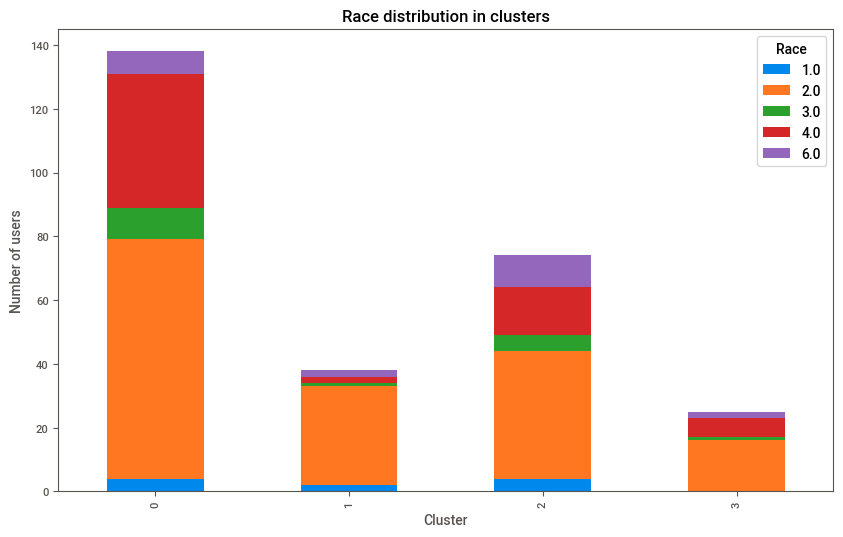

In [186]:
# Visualization of race distribution in clusters

race_mapping = {
    1: 'Black/African American',
    2: 'European/Caucasian-American',
    3: 'Latino/Latino-American',
    4: 'Asian/Pacific Islander/Asian-American',
    5: 'Native American',
    6: 'Other'
}

data_demographics_men['race'] = data_subset_demographics_with_clusters_men['race'].map(race_mapping)

race_distribution_men = data_subset_demographics_with_clusters_men.groupby(['cluster_hierarchical_men', 'race']).size().unstack()
race_distribution_men.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Race distribution in clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of users')
plt.legend(title='Race')
plt.show()

In [187]:
race_distribution_men

race,1.0,2.0,3.0,4.0,6.0
cluster_hierarchical_men,,,,,
0,4.0,75.0,10.0,42.0,7.0
1,2.0,31.0,1.0,2.0,2.0
2,4.0,40.0,5.0,15.0,10.0
3,NaN,16.0,1.0,6.0,2.0


In [188]:
# Checking employment data in clusters
career_column_men = ['iid','career_c']
data_career_men = data_men_filter[career_column_men]
data_career_with_labels_men = data_subset_for_analysis_men.merge(data_career_men[['iid', 'career_c']], on='iid', how='left')

In [189]:
data_career_with_labels_men = data_career_with_labels_men.fillna(data_career_with_labels_men.median())  # Filling missing values with the median

In [190]:
# Checking employment data in clusters
career_column_men = ['iid', 'career_c']
data_career_men = data_men_filter[career_column_men]
data_career_with_labels_men = data_subset_for_analysis_men.merge(data_career_men[['iid', 'career_c']], on='iid', how='left')

In [191]:
data_career_with_labels_men.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_career_with_labels_men.drop(columns=['iid'], inplace=True)

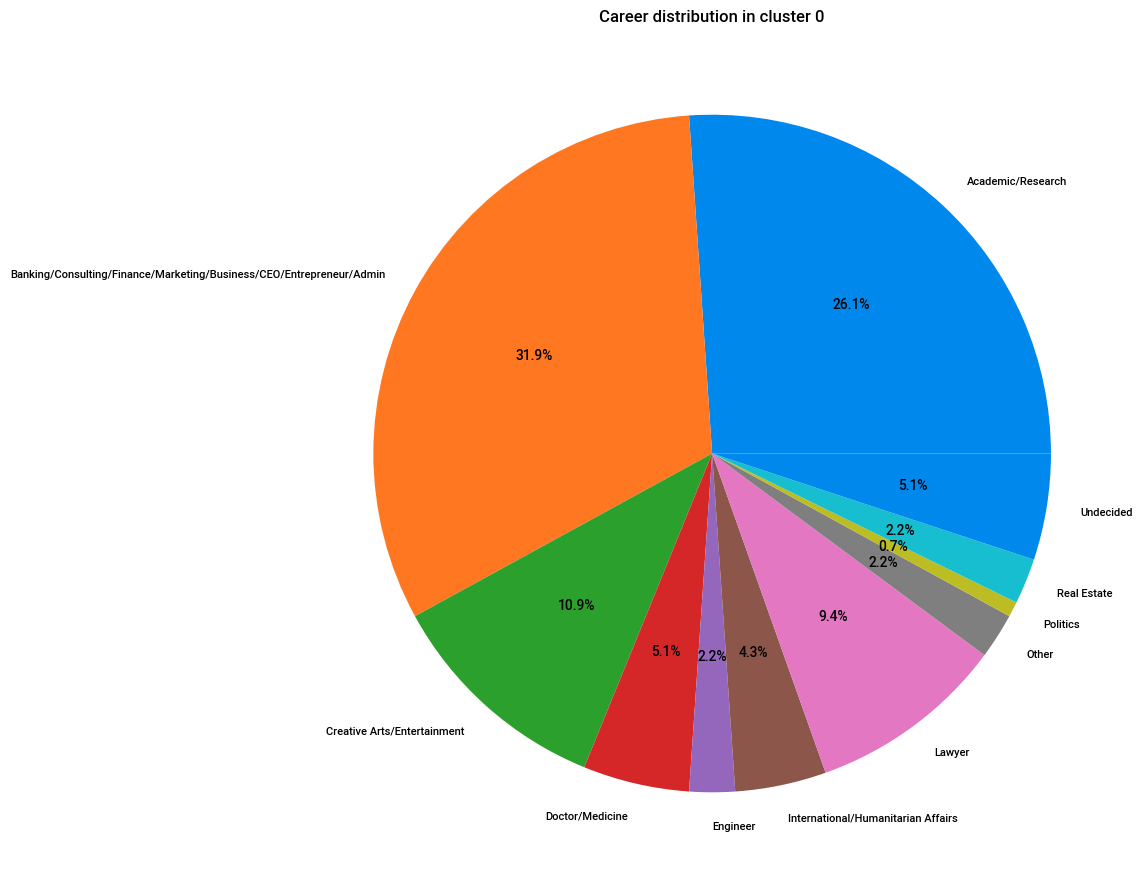

In [192]:
# Mapping career_c values to labels
career_labels_men = {
    1: 'Lawyer',
    2: 'Academic/Research',
    3: 'Psychologist',
    4: 'Doctor/Medicine',
    5: 'Engineer',
    6: 'Creative Arts/Entertainment',
    7: 'Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin',
    8: 'Real Estate',
    9: 'International/Humanitarian Affairs',
    10: 'Undecided',
    11: 'Social Work',
    12: 'Speech Pathology',
    13: 'Politics',
    14: 'Pro sports/Athletics',
    15: 'Other',
    16: 'Journalism',
    17: 'Architecture'
}

# Mapping labels
data_career_with_labels_men['career_c_label_men'] = data_career_with_labels_men['career_c'].map(career_labels_men)

# Analysis of the largest cluster (0)
cluster_0_data_men = data_career_with_labels_men[data_career_with_labels_men['cluster_hierarchical_men'] == 0]
career_distribution_cluster_0_men = cluster_0_data_men.groupby(['career_c_label_men']).size()

# Visualization of career distribution in clusters
plt.figure(figsize=(11, 11))
career_distribution_cluster_0_men.plot(kind='pie', autopct='%1.1f%%')
plt.title('Career distribution in cluster 0')
plt.ylabel('')  # Hide the y-label
plt.show()

In [193]:
# Counting the occurrences of career labels (nicer visualization in Excel)
career_counts_per_cluster_men = data_career_with_labels_men.groupby('cluster_hierarchical_men')['career_c_label_men'].value_counts().unstack()
career_counts_per_cluster_men

career_c_label_men,Academic/Research,Architecture,Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin,Creative Arts/Entertainment,Doctor/Medicine,Engineer,International/Humanitarian Affairs,Lawyer,Other,Politics,Pro sports/Athletics,Psychologist,Real Estate,Undecided
cluster_hierarchical_men,,,,,,,,,,,,,,
0,36.0,NaN,44.0,15.0,7.0,3.0,6.0,13.0,3.0,1.0,NaN,NaN,3.0,7.0
1,7.0,NaN,19.0,1.0,2.0,1.0,1.0,4.0,1.0,2.0,NaN,NaN,NaN,NaN
2,20.0,1.0,27.0,5.0,3.0,3.0,2.0,8.0,NaN,NaN,NaN,1.0,NaN,3.0
3,3.0,NaN,14.0,NaN,NaN,1.0,1.0,4.0,NaN,NaN,1.0,NaN,NaN,1.0


In [194]:
# Names of interests that we will analyze
interests_column_men = ['iid', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
data_interests_men = data_men_filter[interests_column_men]
data_interests_with_labels_men = data_subset_for_analysis_men.merge(data_interests_men[['iid', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']], on='iid', how='left')

In [195]:
data_interests_with_labels_men = data_interests_with_labels_men.fillna(data_interests_with_labels_men.median())  # Filling missing values with the median


In [196]:
data_interests_with_labels_men.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_interests_with_labels_men.drop(columns=['iid'], inplace=True)

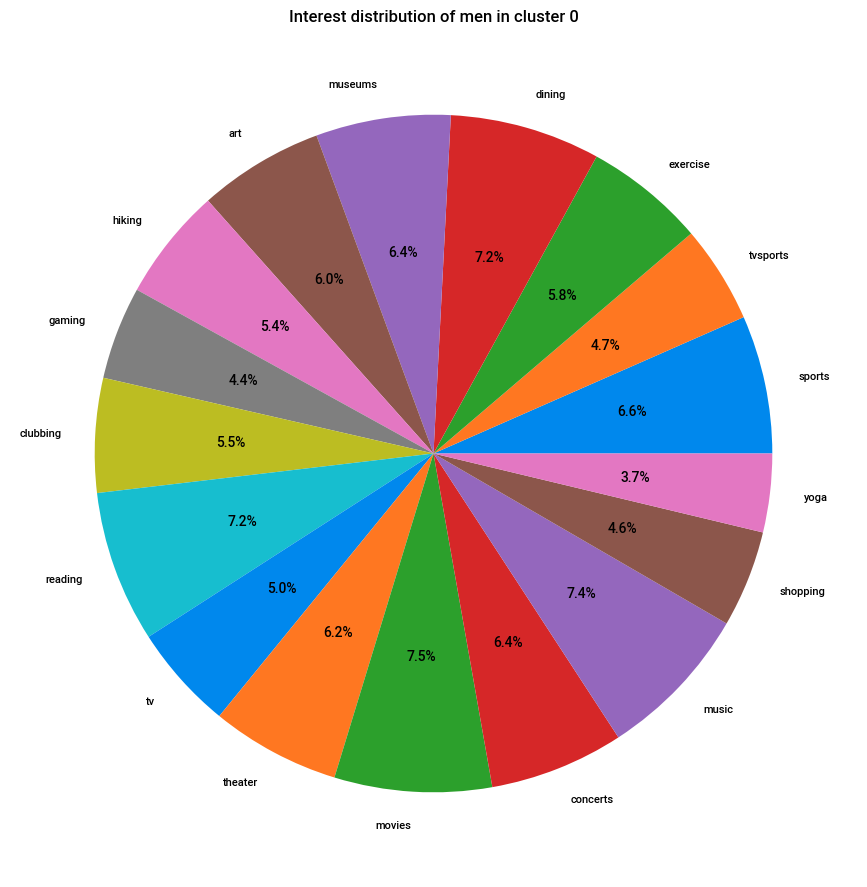

In [197]:
# Analysis of the largest cluster (0)
cluster_0_data_interests_men = data_interests_with_labels_men[data_interests_with_labels_men['cluster_hierarchical_men'] == 0]
interest_distribution_cluster_0_men = cluster_0_data_interests_men[interests_column_men[1:]].sum()

# Visualization of interest distribution in clusters
plt.figure(figsize=(11, 11))
interest_distribution_cluster_0_men.plot(kind='pie', autopct='%1.1f%%')
plt.title('Interest distribution of men in cluster 0')
plt.ylabel('')
plt.show()

In [198]:
# Analysis of the female population
data_women = data_women_filter.loc[:, ['iid', 'attr1_1', 'sinc1_1', 'intel1_1', 'amb1_1', 'shar1_1']].copy()

data_women.drop_duplicates(subset=['iid'], inplace=True)
data_women.drop(columns=['iid'], inplace=True)
data_women = data_women.fillna(data_women.median())

scaler = StandardScaler()
data_women_scaled = scaler.fit_transform(data_women)

hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels_hierarchical_women = hierarchical.fit_predict(data_women_scaled)

labels_hierarchical_women

array([3, 2, 2, 3, 1, 0, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       1, 2, 1, 3, 1, 2, 3, 3, 3, 3, 3, 0, 3, 1, 1, 0, 3, 1, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 0, 3, 3, 3, 0, 1, 3, 3, 0, 1, 3, 1, 3, 3, 2, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 1, 2, 1, 3, 0, 1, 3, 3, 1,
       0, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 1, 0, 1, 1, 1, 3, 1, 3, 3, 0, 3,
       3, 2, 3, 1, 0, 3, 3, 0, 0, 2, 0, 3, 3, 1, 3, 3, 0, 3, 2, 0, 3, 1,
       3, 3, 3, 3, 3, 1, 0, 1, 3, 2, 0, 3, 1, 0, 0, 3, 3, 1, 1, 3, 3, 1,
       1, 1, 3, 1, 0, 2, 3, 1, 3, 0, 3, 1, 0, 3, 0, 1, 1, 3, 1, 1, 3, 1,
       3, 3, 3, 3, 1, 0, 3, 3, 1, 2, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3,
       3, 0, 3, 0, 1, 3, 3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1,
       3, 3, 0, 1, 1, 1, 2, 2, 0, 0])

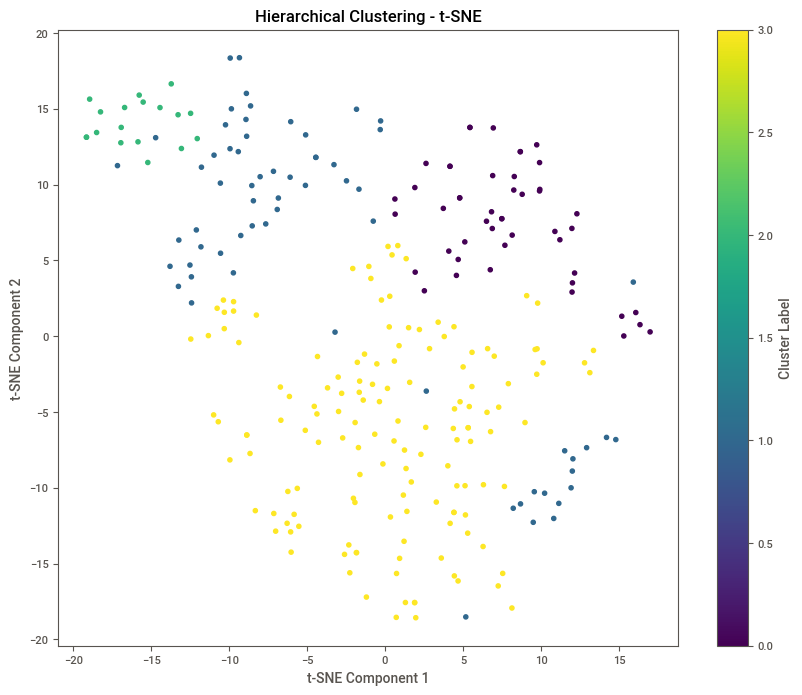

In [199]:
# Dimensionality reduction using t-SNE
# t-SNE reduces the number of dimensions to 2
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_women_scaled)

# t-SNE visualization, point colors represent our clusters
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels_hierarchical_women, cmap='viridis')
plt.title('Hierarchical Clustering - t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [200]:
# Calculating silhouette
silhouette_mean_women = silhouette_score(data_women_scaled, labels_hierarchical_women)
sample_silhouette_values_women = silhouette_samples(data_women_scaled, labels_hierarchical_women)
silhouette_mean_women

0.2372832619383858

In [201]:
lower = 10
for i in range(4):  # 4 clusters
    cluster_silhouette_value_women = sample_silhouette_values_women[labels_hierarchical_women == i]
    cluster_silhouette_value_women.sort()
    size_cluster_i = cluster_silhouette_value_women.shape[0]
    upper = lower + size_cluster_i
    ax1.fill_betweenx(np.arange(lower, upper),
                      0, cluster_silhouette_value_women,
                      facecolor='gray', edgecolor='gray', alpha=0.7)
    ax1.text(-0.05, lower + 0.5 * size_cluster_i, str(i))
    lower = upper + 10

ax1.set_title("Silhouette in clustering")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster number")

# Vertical line indicates the mean silhouette value
ax1.axvline(x=silhouette_mean_women, color="red", linestyle="--")
# Hiding y-axis labels
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.5, 1, 0.1))

# Displaying the plot
plt.show()

In [202]:
# Conclusions from clustering data about women
data_subset_women_with_labels = data_women.copy()
data_subset_women_with_labels['cluster_hierarchical_women'] = labels_hierarchical_women

# Calculating mean feature values for each cluster
cluster_means_women = data_subset_women_with_labels.groupby('cluster_hierarchical_women').mean()

cluster_means_women

,attr1_1,sinc1_1,intel1_1,amb1_1,shar1_1
cluster_hierarchical_women,,,,,
0,14.197917,23.345625,18.637083,8.439375,19.121042
1,17.555231,15.725846,27.650308,9.495077,10.416769
2,46.555556,8.444444,22.222222,7.722222,4.845000
3,15.820559,18.930140,18.526923,16.516783,12.588601


In [203]:
# Number of people in each cluster for women
data_subset_women_with_labels['cluster_hierarchical_women'].value_counts()

cluster_hierarchical_women
3    143
1     65
0     48
2     18
Name: count, dtype: int64

In [204]:
# Demographic data
data_subset_for_analysis_women = data_subset_women_with_labels.merge(data_women_filter[['iid']], left_index=True, right_index=True)
demographic_columns_women = ['iid', 'age', 'race']
data_demographics_women = data_women_filter[demographic_columns_women]
data_subset_demographics_with_clusters_women = data_subset_for_analysis_women.merge(data_demographics_women[['iid', 'age', 'race']], on='iid', how='left')

In [205]:
data_subset_demographics_with_clusters_women = data_subset_demographics_with_clusters_women.fillna(data_subset_demographics_with_clusters_women.median())  # Filling missing values with the median

In [206]:
data_subset_demographics_with_clusters_women.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_subset_demographics_with_clusters_women.drop(columns=['iid'], inplace=True)

In [207]:
# Calculating mean values of demographic features for each cluster (only for the numeric column, i.e., age)
cluster_demographics_women = data_subset_demographics_with_clusters_women.groupby('cluster_hierarchical_women')['age'].mean()
cluster_demographics_women_1 = data_subset_demographics_with_clusters_women.groupby('cluster_hierarchical_women')['age'].median()
cluster_demographics_women  # Checking the mean


cluster_hierarchical_women
0    26.562500
1    26.246154
2    25.333333
3    26.020979
Name: age, dtype: float64

In [208]:
cluster_demographics_women_1

cluster_hierarchical_women
0    26.0
1    25.0
2    24.5
3    26.0
Name: age, dtype: float64

In [209]:
# Race distribution among women in clusters - data used for visualization in Excel
race_mapping_women = {
    1: 'Black/African American',
    2: 'European/Caucasian-American',
    3: 'Latino/Latino-American',
    4: 'Asian/Pacific Islander/Asian-American',
    5: 'Native American',
    6: 'Other'
}

data_demographics_women['race'] = data_subset_demographics_with_clusters_women['race'].map(race_mapping_women)

race_distribution_women = data_subset_demographics_with_clusters_women.groupby(['cluster_hierarchical_women', 'race']).size().unstack()
race_distribution_women

race,1.0,2.0,3.0,4.0,6.0
cluster_hierarchical_women,,,,,
0,2,22,1,17,6
1,1,33,10,18,3
2,1,8,3,5,1
3,12,83,11,31,6


In [210]:
# Checking employment data in clusters
career_column_women = ['iid', 'career_c']
data_career_women = data_women_filter[career_column_women]
data_career_with_labels_women = data_subset_for_analysis_women.merge(data_career_women[['iid', 'career_c']], on='iid', how='left')

In [211]:
data_career_with_labels_women = data_career_with_labels_women.fillna(data_career_with_labels_women.median())  # Filling missing values with the median

In [212]:
data_career_with_labels_women.drop_duplicates(subset=['iid'], inplace=True)  # Removing duplicates based on iid
data_career_with_labels_women.drop(columns=['iid'], inplace=True)

In [213]:
career_labels_women = {
    1: 'Lawyer',
    2: 'Academic/Research',
    3: 'Psychologist',
    4: 'Doctor/Medicine',
    5: 'Engineer',
    6: 'Creative Arts/Entertainment',
    7: 'Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin',
    8: 'Real Estate',
    9: 'International/Humanitarian Affairs',
    10: 'Undecided',
    11: 'Social Work',
    12: 'Speech Pathology',
    13: 'Politics',
    14: 'Pro sports/Athletics',
    15: 'Other',
    16: 'Journalism',
    17: 'Architecture'
}

# Mapping labels
data_career_with_labels_women['career_c_label_women'] = data_career_with_labels_women['career_c'].map(career_labels_women)

# Analysis of the largest cluster (3)
cluster_2_data_women = data_career_with_labels_women[data_career_with_labels_women['cluster_hierarchical_women'] == 3]
career_distribution_cluster_2_women = cluster_2_data_women.groupby(['career_c_label_women']).size()
career_distribution_cluster_2_women

career_c_label_women
Academic/Research                                                       47
Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin    27
Creative Arts/Entertainment                                              9
Doctor/Medicine                                                          7
Engineer                                                                 9
International/Humanitarian Affairs                                      19
Lawyer                                                                   9
Politics                                                                 1
Psychologist                                                             4
Social Work                                                              4
Undecided                                                                7
dtype: int64

In [214]:
interests_column_women = ['iid','sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
data_interests_women = data_women_filter[interests_column_women]
data_interests_with_labels_women = data_subset_for_analysis_women.merge(data_interests_women[['iid','sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga' ]], on='iid', how='left')

In [215]:
data_interests_with_labels_women = data_interests_with_labels_women.fillna(data_interests_with_labels_women.median())

In [216]:
data_interests_with_labels_women.drop_duplicates(subset=['iid'], inplace=True)
data_interests_with_labels_women.drop(columns=['iid'], inplace=True)

In [217]:
# Analysis of the largest cluster
cluster_2_data_interests_women = data_interests_with_labels_women[data_interests_with_labels_women['cluster_hierarchical_women'] == 3]
interest_distribution_cluster_2_women = cluster_2_data_interests_women[interests_column_men[1:]].sum()
interest_distribution_cluster_2_women

sports       834.0
tvsports     610.0
exercise     951.0
dining      1153.0
museums     1057.0
art         1018.0
hiking       850.0
gaming       463.0
clubbing     852.0
reading     1127.0
tv           840.0
theater     1077.0
movies      1168.0
concerts    1025.0
music       1169.0
shopping     964.0
yoga         723.0
dtype: float64